In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta

/Users/jteruya/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Matlab Plot Settings

In [2]:
# Display Plot within Jupyter Notebook
%matplotlib inline
# Default Plot Size
plt.rcParams['figure.figsize'] = [10, 10]

## Index Data

In [16]:
# Helper Function
def download_data(ticker, start, end):
    return yf.download(ticker, start, end)

# Start and End Dates for Ticker Data
start_date = "2018-01-01"
end_date = "2021-01-07"
# List of Indices to Retrieve Data
indices = ["^VIX", "^GSPC", "^DJI", "^TNX", "DX-Y.NYB", "GLD", "TIP", "VNQ"]
# List of lists
indices_data = [download_data(index, start_date, end_date) for index in indices]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Percent Movement Per Index
Calculate the % change for each day

In [17]:
# Previous Closing
def previous_close(df):
    df['Previous Close'] = df['Close'].shift(1)
    return df

# Percent Movement Helper Function
def market_movement(row):
    return (row['Close'] - row['Previous Close'])/row['Previous Close']

# Get Previous Close to Account for Futures
indices_data_prev = [previous_close(df) for df in indices_data]

# Apply helper function to all index dataframes
percent_movement = [index.apply(market_movement, axis=1) for index in indices_data_prev]

## Visualize Percent Market Per Day

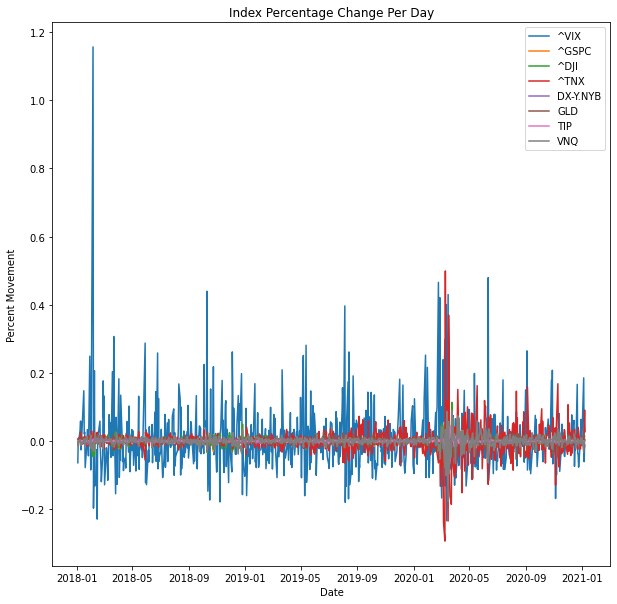

In [18]:
for x in range(len(indices)):
    plt.plot(percent_movement[x], label=indices[x])
plt.xlabel('Date')
plt.ylabel('Percent Movement')
plt.title('Index Percentage Change Per Day')
plt.legend()
plt.show()

## Create Daily Dataframe for Correlation Calculations

In [19]:
# Inital Correlation Dataframe
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
original_columns = all_indices_df.columns
all_indices_df['Day'] = all_indices_df.index

# Add Timeshifts (by Day)
max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

# Direction Change
all_indices_df['GSPC Same Direction'] = (all_indices_df['GSPC Percent Movement'].shift(1) > 0)^(all_indices_df['GSPC Percent Movement'] < 0)
all_indices_df['VIX Same Direction'] = (all_indices_df['VIX Percent Movement'].shift(1) > 0)^(all_indices_df['VIX Percent Movement'] < 0)
        
# Directional Streak ID
all_indices_df['GSPC Streak'] = 0
all_indices_df['VIX Streak'] = 0

all_indices_df['GSPC Streak'] = all_indices_df.apply(lambda x: 1 if not(x['GSPC Same Direction']) else x['GSPC Streak'], axis=1).cumsum()
all_indices_df['VIX Streak'] = all_indices_df.apply(lambda x: 1 if not(x['VIX Same Direction']) else x['VIX Streak'], axis=1).cumsum()

# Count the consecutive days of a particular streak
all_indices_df['GSPC Streak Consecutive Days'] = all_indices_df.groupby("GSPC Streak")['Day'].rank("dense", ascending=True)
all_indices_df['VIX Streak Consecutive Days'] = all_indices_df.groupby("VIX Streak")['Day'].rank("dense", ascending=True)

# Dependent Variable
all_indices_df['VIX Same Direction Next Day'] = all_indices_df['VIX Same Direction'].shift(-1)

# Correlations on Columns
all_indices_df.tail(10)

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,TNX Percent Movement,X-Y.NYB Percent Movement,LD Percent Movement,IP Percent Movement,NQ Percent Movement,Day,VIX Percent Movement + 1 Day Shift,...,LD Percent Movement + 3 Day Shift,IP Percent Movement + 3 Day Shift,NQ Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days,VIX Same Direction Next Day
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-23,-0.037969,0.000746,0.003809,0.040305,-0.002648,0.006648,0.000472,-0.006468,2020-12-23,-0.076362,...,0.003642,-0.000471,-0.008533,False,True,390,392,1.0,2.0,True
2020-12-24,-0.076362,0.003537,0.002325,NaN,NaN,0.003985,0.000393,-0.007220,2020-12-24,0.007896,...,0.007655,0.000786,0.005498,True,True,390,392,2.0,3.0,False
2020-12-28,0.007896,0.008723,0.006758,-0.023037,-0.000774,-0.003629,0.000707,0.005961,2020-12-28,0.063594,...,0.003714,0.002120,0.009629,True,False,390,393,3.0,1.0,True
2020-12-29,0.063594,-0.002227,-0.002246,0.002144,-0.003653,0.003642,-0.000471,-0.008533,2020-12-29,-0.013432,...,0.022258,0.001097,-0.032497,False,True,391,393,1.0,2.0,False
2020-12-30,-0.013432,0.001342,0.002436,-0.009626,-0.004222,0.007655,0.000786,0.005498,2020-12-30,-0.000878,...,0.002962,-0.000313,0.001460,False,False,392,394,1.0,1.0,True
2020-12-31,-0.000878,0.006439,0.006476,-0.009719,0.003459,0.003714,0.002120,0.009629,2020-12-31,0.185494,...,-0.016241,-0.002975,0.001701,True,True,392,394,2.0,2.0,False
2021-01-04,0.185494,-0.014755,-0.012500,0.000000,-0.000667,0.022258,0.001097,-0.032497,2021-01-04,-0.060437,...,NaN,NaN,NaN,False,False,393,395,1.0,1.0,False
2021-01-05,-0.060437,0.007083,0.005549,0.041439,-0.004895,0.002962,-0.000313,0.001460,2021-01-05,-0.010655,...,NaN,NaN,NaN,False,False,394,396,1.0,1.0,True
2021-01-06,-0.010655,0.005710,0.014405,0.091100,0.001006,-0.016241,-0.002975,0.001701,2021-01-06,NaN,...,NaN,NaN,NaN,True,True,394,396,2.0,2.0,False


## Preprocessing

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

independent_variables = ['GSPC Percent Movement', 'TNX Percent Movement', 'X-Y.NYB Percent Movement', 'LD Percent Movement', 'IP Percent Movement', 'NQ Percent Movement']

X = all_indices_df[independent_variables][2:-2]
y = all_indices_df['VIX Same Direction Next Day'][2:-2]

# Fill Non null values with mean
X.fillna(X.mean(), inplace=True)

# Categorical Label Encoder for Dependent Variable
le = preprocessing.LabelEncoder()

# Encode Categorical Dependent Variable
le.fit(y)
y = le.transform(y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Random Forest Directional Model

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=0, shuffle=False)

clf = RandomForestClassifier(max_depth=4, random_state=0)

# Train the Model
model = clf.fit(X_train, y_train)

model.predict(X_test)
model.predict_proba(X_test)

# Score the Model
model.score(X_test, y_test)

0.5592105263157895

## Logisitical Regression Directional Model

In [22]:
from sklearn.linear_model import LogisticRegression

# Train the Model
model = LogisticRegression(random_state=0).fit(X_train, y_train)

model.predict(X_test)
model.predict_proba(X_test)

# Score the Model
model.score(X_test, y_test)

0.4934210526315789

## Save Model

In [ ]:
model_file_handler = open("models/vix_prediction.pl",'wb')
pickle.dump(model, model_file_handler)
model_file_handler.close()

## Prediction

In [ ]:
model_file_handler = open("models/vix_prediction.pl",'rb')
model = pickle.load(model_file_handler)

In [ ]:
# Prediction
base = datetime(2020,12,1)
date_list = [base - timedelta(days=x) for x in range(100)]

for date in date_list:
    date_index = date.strftime("%Y-%m-%d")
    try:
        print(date_index)
        print(model.predict_proba([all_indices_df.loc[date_index][independent_variables]]))
        print(model.predict([all_indices_df.loc[date_index][independent_variables]]))
    except:
        print("No Trading Day")
        pass
    print("\n")

## Calculate Correlations

In [ ]:
# Correlations on Columns
all_indices_df.corr(method ='pearson')

## Monthly Correlations

In [ ]:
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
all_indices_df['Month'] = all_indices_df.index.year * 100 + all_indices_df.index.month

months = all_indices_df['Month'].unique().tolist()

max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

all_indices_df = all_indices_df.groupby(['Month']).corr(method ='pearson')

vix = []
dji = []
vix_1 = []
dji_1 = []
vix_2 = []
dji_2 = []
vix_3 = []
dji_3 = []

for month in months:
    monthly_indices_df = all_indices_df.loc[month, "GSPC Percent Movement"]
    vix.append(monthly_indices_df['VIX Percent Movement'])
    dji.append(monthly_indices_df['DJI Percent Movement'])
    vix_1.append(monthly_indices_df['VIX Percent Movement + 1 Day Shift'])
    dji_1.append(monthly_indices_df['DJI Percent Movement + 1 Day Shift'])
    vix_2.append(monthly_indices_df['VIX Percent Movement + 2 Day Shift'])
    dji_2.append(monthly_indices_df['DJI Percent Movement + 2 Day Shift'])
    vix_3.append(monthly_indices_df['VIX Percent Movement + 3 Day Shift'])
    dji_3.append(monthly_indices_df['DJI Percent Movement + 3 Day Shift'])
    
monthly_data = {'MONTH': [datetime.strptime(str(month), '%Y%m') for month in months], 'VIX': vix, 'DOW': dji, 'VIX+1': vix_1, 'DJI+1': dji_1, 'VIX+2': vix_2, 'DJI+2': dji_2, 'VIX+3': vix_3, 'DJI+3': dji_3}
monthly_df = pd.DataFrame(data = monthly_data).set_index('MONTH')
#monthly_df.to_csv('sp500_correlation_raw.csv')
monthly_df


## Plot Monthly Correlations over Time for SP500

In [ ]:
for x in range(len(monthly_df.columns)):
    plt.plot(monthly_df[monthly_df.columns[x]], label=monthly_df.columns[x])
plt.xlabel('Month')
plt.ylabel('Correlation')
plt.title('SP500 Correlation Per Month')
plt.legend()
plt.show()